Рассматривается задача классификации текстов - tweet sentement analytics

Были использованы рускоязычные твиты из открытого датасета:
http://study.mokoron.com

In [1]:
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tokenizers import ByteLevelBPETokenizer
from tokenizers.decoders import ByteLevel

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Embedding, Flatten, MaxPooling1D, Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping

from IPython.display import clear_output
import matplotlib.pyplot as plt

from my_f1_metric import F1Score

<h2>1. Формируем датасет</h2>

In [2]:
#функция для очистки текстов от лишних данных

def clear_text(text):
    """
        функция для очистки текста:
            приведение к нижнему регистру
            замена «ё» на «е»
            замена ссылок на токен «URL»
            замена упоминания пользователя на токен «USER»
    """
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'url', text)
    text = re.sub('@[^\s]+', 'user', text)

    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


# считываем данные
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

# формируем датасет
raw_data = np.concatenate([data_positive['text'].values, data_negative['text'].values])
texts = [clear_text(text) for text in raw_data] # чистим тексты
labels = np.array([1] * data_positive.shape[0] + [0] * data_negative.shape[0])

# разделяем датасет на train/test
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=1)
# дополнительно разделим train на train/val для отслеживания возможного переобучения
texts_train, texts_val, labels_train, labels_val = train_test_split(texts_train, labels_train, test_size=0.2, random_state=1)

<h2> 2. Создаем токенизатор</h2>

In [3]:
# сохраняем train-датасет для дальнейшего обучения токенизатора
with open('dataset_for_tokenizer.txt', 'w') as f:
    f.write('\n\n'.join(texts_train))

# обучаем токенизатор
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(['dataset_for_tokenizer.txt'], vocab_size=20000, min_frequency=2)

# сохраняем обученный токенизатор
tokenizer.save(".", "my_tokenizer")

TypeError: 

In [4]:
# пример работы токенизатора

decoder = ByteLevel()
tokenizer.enable_truncation(max_length=512)

output = tokenizer.encode("слушай я тебя как-то обидела что ли?")

print(output.ids)
print([decoder.decode(token) for token in output.tokens])
print(output.offsets)

[4517, 400, 313, 521, 370, 12, 294, 17678, 348, 972, 30]
[&#39;слуш&#39;, &#39;ай&#39;, &#39; я&#39;, &#39; тебя&#39;, &#39; как&#39;, &#39;-&#39;, &#39;то&#39;, &#39; обидела&#39;, &#39; что&#39;, &#39; ли&#39;, &#39;?&#39;]
[(0, 4), (4, 6), (6, 8), (8, 13), (13, 17), (17, 18), (18, 20), (20, 28), (28, 32), (32, 35), (35, 36)]


<h2>3. Создаем и обучаем модель нейронной сети</h2>

<h3>3.1 Подготовим датасет для обучения</h3>

In [14]:
# токенизируем все наши тексты в train/val-выборке
tokens_train = [np.array(tokenizer.encode(text).ids) for text in texts_train]
tokens_val = [np.array(tokenizer.encode(text).ids) for text in texts_val]

# приводим входные данные к единому виду (длина последовательности = 64)
data_train = sequence.pad_sequences(tokens_train, maxlen=64)
data_val = sequence.pad_sequences(tokens_val, maxlen=64)

<h3>3.4 Создадим калбэки для удобного отслеживания обучения</h3>

In [6]:
# callback для отображения графиков обучения
class PlotStats(Callback):
    """
        отображение графиков метрик в режиме реального времени
    """
    def __init__(self, metrics):
        self.metrics = metrics
        self.stats = dict()
        
        for metric in self.metrics:
            self.stats.update({
                metric: [],
                'val_%s' % metric: []
            })
        
        self.rows = int(round(len(self.metrics) / 2))
        self.cols = 2

        plt.ion()
        plt.rcParams["figure.figsize"] = (15, 5)
        plt.rcParams["axes.grid"] = True    
    
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        fig = plt.figure(figsize=(15, self.rows * 5))
        x = list(range(len(self.stats['loss']) + 1))
        
        for mi, metric in enumerate(self.metrics):
            self.stats[metric].append(logs.get(metric))
            self.stats['val_%s' % metric].append(logs.get('val_%s' % metric))
            
            a_metric = fig.add_subplot(self.rows, self.cols, mi + 1)
            a_metric.plot(x, self.stats[metric], label=metric)
            a_metric.plot(x, self.stats['val_%s' % metric], label='val_%s' % metric)
            a_metric.legend()
        
        plt.show()

# callback для сохранения лучшей модели
class SaveBestModel(Callback):
    """
        сохранение лучшей модели
    """
    def __init__(self, target_metric, mode='max'):
        self.target_metric = target_metric
        self.mode = mode

        if self.mode == 'max':
            self.best_metric = 0.
            self.minimize = False
        elif self.mode == 'min':
            self.best_metric = 1.
            self.minimize = True
        else:
            raise TypeError('Invalid mode type. Should be "max" or "min"')
    
    def on_epoch_end(self, epoch, logs={}):
        current_metric = logs[self.target_metric]
        if current_metric > self.best_metric and not self.minimize:
            self.update_model(current_metric)
        elif current_metric < self.best_metric and self.minimize:
            self.update_model(current_metric)

    def update_model(self, metric_val):
        self.best_metric = metric_val
        model.save('model.h5')
        

<h3>3.3 Создадим модель сети</h3>

In [24]:
# формируем модель нейронной сети (сверточную)
from tensorflow.keras.layers import Dropout
def make_model():
    model = Sequential()
    model.add(Embedding(tokenizer.get_vocab_size(), 32, input_length=64))

    model.add(Conv1D(16, 3, padding='same', activation='relu'))
    model.add(Conv1D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())

    model.add(Conv1D(16, 3, padding='same', activation='relu'))
    model.add(Conv1D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())

    model.add(Conv1D(16, 3, padding='same', activation='relu'))
    model.add(Conv1D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = make_model()
model.summary()

Model: &quot;sequential_16&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 64, 32)            640000    
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 64, 16)            1552      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 64, 16)            784       
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 32, 16)            0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 32, 16)            784       
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 32, 16)            784       
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 16, 16)

<h3>3.4 Обучаем модель</h3>

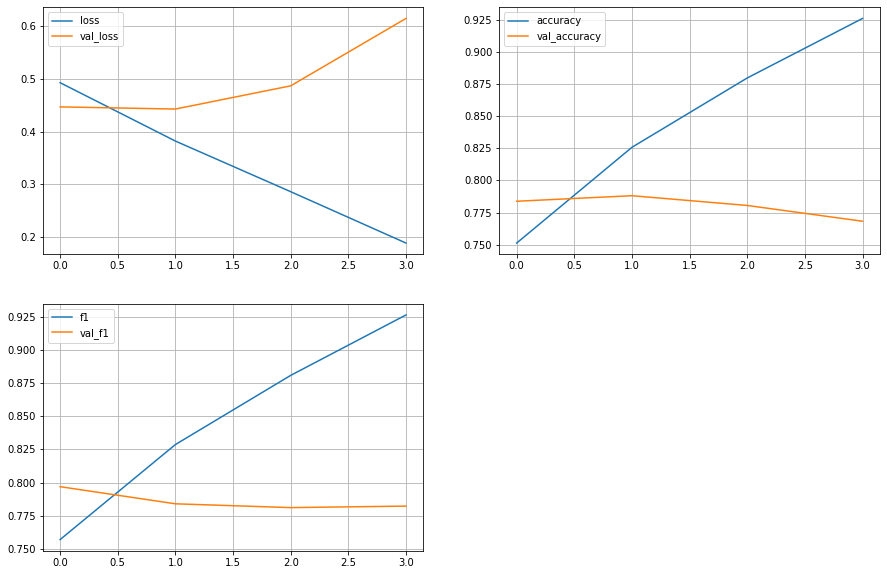

4537/4537 [==============================] - 55s 12ms/step - loss: 0.1887 - accuracy: 0.9260 - f1: 0.9267 - val_loss: 0.6145 - val_accuracy: 0.7683 - val_f1: 0.7822


&lt;tensorflow.python.keras.callbacks.History at 0x7ff422798d50&gt;

In [23]:
# добавляем свою метрику f1
f1Score = F1Score(name='f1')

# ранняя остановка обучения
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# отрисовка процесса обучения (графиков)
plot_stats = PlotStats(metrics=['loss', 'accuracy', 'f1'])

# сохранение лучшей модели
save_best_model = SaveBestModel('val_f1', mode='max')

# обучаем модель
model = make_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1Score])
model.fit(data_train, labels_train, 
          epochs=5,
          callbacks=[plot_stats, save_best_model, early_stopping],
          validation_data=(data_val, labels_val))

In [19]:
# загрузим лучшую модель
best_model = make_model()
best_model.load_weights('model.h5')

# токенизируем тексты
texts_test = np.array(texts_test)
tokens_test = [np.array(tokenizer.encode(text).ids) for text in texts_test]

# приводим токенизированные тексты к длинне 64
data_test = sequence.pad_sequences(tokens_test, maxlen=64)

# получаем предсказание модели для test-выборки
predict = best_model.predict(data_test)

# выведем число ошибочных текстов и точность (accuracy)
errors = np.abs(np.round(predict[:,0]) - labels_test)
error_cnt = errors.sum()
error_texts = texts_test[errors != 0]
acc = 1 - error_cnt/len(labels_test)

print('accuracy на test-выборке: {}'.format(acc))
print('число ошибок: {}'.format(error_cnt))

accuracy на test-выборке: 0.778032490576851
число ошибок: 10070.0


In [90]:
# выведем на экран несколько примеров, для которых сеть ошиблась
print('groud_th\ttext')
for text, label in zip(error_texts[:10], labels_test[:10]):
    print(label, '\t=>\t', text)

groud_th	text
0 	=>	 кашель заипал уже и на грелках лежала и картошку клали
0 	=>	 user ах если бы покрасилась натуральной краской а она вместо рыжего оттенка дала темный я снова шатенка
0 	=>	 user user user ух твидл становится популярным пора принимать меры
0 	=>	 user сегодня 2 твердыни показывают
0 	=>	 да и вообще я так люблю свой факультет так люблю учебу на нем но сессия
0 	=>	 две недельки продержаться скорей бы уже каникулы задолбала эта школа
0 	=>	 user user апокалипсис идет к нам всемирное потепление
1 	=>	 user и ищет он плохо приходится пользоваться duckduckgo
1 	=>	 отлично на всю говно ситуацию в школе родители лишь злобно посмеялись и да походу я не буду дворником
1 	=>	 сайн яваа нэгэндээ саад буу болоорой хуухдууд ингэж дуулж бн шдээ томчууд аа
